# Demo 2 - Remote parallel computation [distributed]

Demo for site visit | Brendan Smithyman | April 8, 2015

## Choice of IPython / jupyter cluster profile

In [1]:
# profile = 'phobos'   # remote workstation
# profile = 'pantheon' # remote cluster
profile = 'mpi' # local machine

## Importing libraries

- `numpy` is the *de facto* standard Python numerical computing library
- `zephyr.Dispatcher` is *zephyr*'s primary parallel remote problem interface
- `IPython.parallel` provides parallel task control (nominally, this is to be handled inside the `Dispatcher` object)

In [2]:
import numpy as np
from zephyr.Dispatcher import SeisFDFDDispatcher
from IPython.parallel import Reference

## Plotting configuration

These lines import `matplotlib`, which is a standard Python plotting library, and configure the output formats for figures.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

# Plotting options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

These lines define some plotting functions, which are used later.

In [4]:
lclip = 2000
hclip = 3000
clipscale = 0.1
sms = 0.5
rms = 0.5

def plotField(u):
    clip = clipscale*abs(u).max()
    plt.imshow(u.real, cmap=cm.bwr, vmin=-clip, vmax=clip)

def plotModel(v):
    plt.imshow(v.real, cmap=cm.jet, vmin=lclip, vmax=hclip)

def plotGeometry(geom):
    
    srcpos = geom['src'][:,::2]
    recpos = geom['rec'][:,::2]
    
    axistemp = plt.axis()
    plt.plot(srcpos[:,0], srcpos[:,1], 'kx', markersize=sms)
    plt.plot(recpos[:,0], recpos[:,1], 'kv', markersize=rms)
    plt.axis(axistemp)

## System / modelling configuration

This code sets up the seismic problem; see the comments inline. In a live inversion problem this would most likely be read from a configuration file (but could be defined interactively for development purposes).

### Properties of the grid and forward modelling

In [5]:
cellSize    = 1             # m
nx          = 164           # count
nz          = 264           # count
freqs       = [1e2, 2e2, 3e2, 4e2]         # Hz
freeSurf    = [False, False, False, False] # t r b l
nPML        = 32            # number of PML points
nky         = 1             # number of y-directional plane-wave components

### Properties of the model

In [6]:
velocity    = 2500          # m/s
vanom       = 500           # m/s
density     = 2700          # units of density
Q           = 500           # can be inf

### Array geometry

In [7]:
srcs        = np.array([np.ones(101)*32, np.zeros(101), np.linspace(32, 232, 101)]).T
recs        = np.array([np.ones(101)*132, np.zeros(101), np.linspace(32, 232, 101)]).T
nsrc        = len(srcs)
nrec        = len(recs)
recmode     = 'fixed'

geom        = {
    'src':  srcs,
    'rec':  recs,
    'mode': 'fixed',
}

### Numerical / parallel parameters

In [8]:
cache       = False         # whether to cache computed wavefields for a given source
cacheDir    = '.'

parFac = 2
chunksPerWorker = 0.5       # NB: parFac * chunksPerWorker = number of source array subsets
ensembleClear = False

### Computed properties

In [9]:
dims        = (nx,nz)       # tuple
rho         = np.fliplr(np.ones(dims) * density)
nfreq       = len(freqs)    # number of frequencies
nsp         = nfreq * nky   # total number of 2D subproblems
cPert       = np.zeros(dims)
cPert[(nx/2)-20:(nx/2)+20,(nz/2)-20:(nz/2)+20] = vanom
c           = np.fliplr(np.ones(dims) * velocity)
cFlat       = c
c          += np.fliplr(cPert)
cTrue       = c

## Problem geometry

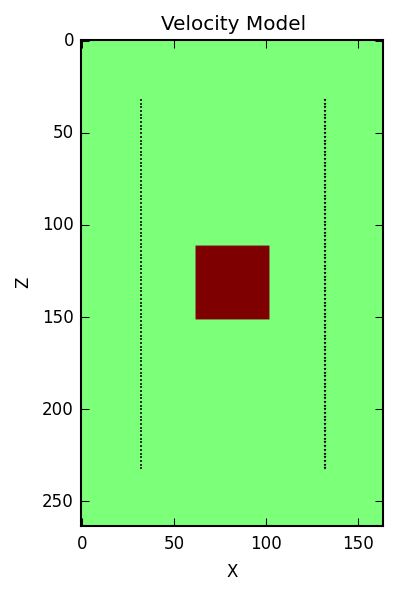

In [10]:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
plotModel(c.T)
plotGeometry(geom)
ax1.set_title('Velocity Model')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')

fig.tight_layout()

## Configuration dictionary

(assembled from previous sections)

In [11]:
# Base configuration for all subproblems
systemConfig = {
    'dx':   cellSize,       # m
    'dz':   cellSize,       # m
    'c':        c.T,        # m/s
    'rho':      rho.T,      # density
    'Q':        Q,          # can be inf
    'nx':       nx,         # count
    'nz':       nz,         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'cache':    cache,
    'cacheDir': cacheDir,
    'freqs':    freqs,
    'nky':      nky,
    'parFac':   parFac,
    'chunksPerWorker':  chunksPerWorker,
    'profile':  profile,
    'ensembleClear':    ensembleClear,
#     'MPI': False,
#    'Solver':   Reference('SimPEG.SolverWrapD(scipy.sparse.linalg.splu)'),#Solver,
}

## Parallel computations

This section runs each of the parallel computations on the remote worker nodes.

### Set up problem

- Create the `Dispatcher` object using the `systemConfig` dictionary as input
- Spawn `survey` and `problem` interfaces, which implement the *SimPEG* standard properties
- Generate a set of "transmitter" objects, each of which knows about its respective "receivers" (in seismic parlance, these would be "sources" and "receivers"; the term "transmitter" is more common in EM and potential fields geophysics)
- Tell the dispatcher object about the transmitters

In [12]:
%%time
sp = SeisFDFDDispatcher(systemConfig)
survey, problem = sp.spawnInterfaces()
txs = survey.genTx()
sp.txs = txs

CPU times: user 264 ms, sys: 35.8 ms, total: 300 ms
Wall time: 968 ms


### Forward modelling and backpropagation

Example (commented out) showing how to generate synthetic data using the *SimPEG*-style `survey` and `problem` interfaces. In this implementation, both are essentially expressions of the `Dispatcher`. The `Dispatcher` API has yet to be merged into *SimPEG*.

In [13]:
# d = survey.projectFields()
# uF = problem.fields()

This code runs the forward modelling on the [remote] workers. It returns asynchronously, so the code can run in the background.

In [14]:
%%time
sp.forward()

CPU times: user 22.5 ms, sys: 2.62 ms, total: 25.1 ms
Wall time: 27.2 ms


However, it will block if we ask for the data or wavefields:

In [15]:
%%time
d = sp.dPred
uF = sp.uF

CPU times: user 3.67 s, sys: 1.14 s, total: 4.8 s
Wall time: 31.1 s


In [16]:
d[0].shape

(101, 101)

The code below backpropagates the data residuals for all sources.

In this case, since they haven't been set, this is just backpropagating $\delta d_{isrc} = 1$ for all $isrc$.

In [17]:
%%time
sp.backprop()
uB = sp.uB

CPU times: user 375 ms, sys: 433 ms, total: 808 ms
Wall time: 1.97 s


The gradient may also be computed:

- All of these computations happen on the remote cluster
- The result is only transferred to the frontend after it has been reduced in parallel using MPI.

In [18]:
%%time
g = sp.g

CPU times: user 144 ms, sys: 32.4 ms, total: 176 ms
Wall time: 1.54 s


## Results

We show the resulting data and wavefield properties.

Data selection:

In [19]:
freqNum = 0
srcNum = 0

frt = uF[freqNum]
brt = uB[freqNum]
drt = d[freqNum]
grt = g[freqNum]
clipScaleF = 1e-1 * abs(frt[srcNum]).max()
clipScaleB = 1e-1 * abs(brt[srcNum]).max()
clipScaleG = 1e-1 * abs(grt).max()

Geometry and data:

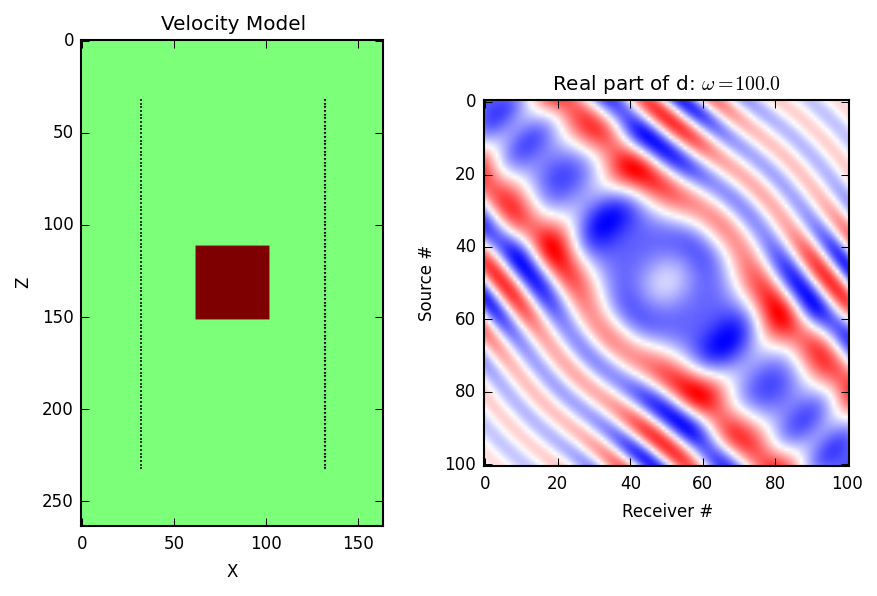

In [20]:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
plotModel(c.T)
plotGeometry(geom)
ax1.set_title('Velocity Model')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')

ax2 = fig.add_subplot(1,2,2)
plt.imshow(drt.real, cmap=cm.bwr)
ax2.set_title('Real part of d: $\omega = %0.1f$'%(freqs[freqNum],))
ax2.set_xlabel('Receiver #')
ax2.set_ylabel('Source #')

fig.tight_layout()

Forward wavefield, backpropagated wavefield, gradient:

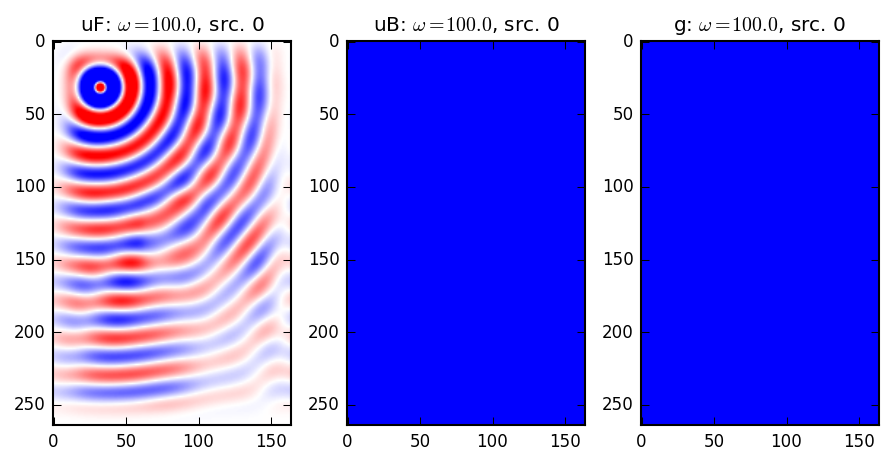

In [21]:
fig = plt.figure()

ax2 = fig.add_subplot(1,3,1)
plt.imshow(frt[srcNum].real, vmin=-clipScaleF, vmax=clipScaleF, cmap=cm.bwr)
plt.title('uF: $\omega = %0.1f$, src. %d'%(freqs[freqNum], srcNum))

ax3 = fig.add_subplot(1,3,2)
plt.imshow(brt[srcNum].real, vmin=-clipScaleB, vmax=clipScaleB, cmap=cm.bwr)
plt.title('uB: $\omega = %0.1f$, src. %d'%(freqs[freqNum], srcNum))

ax4 = fig.add_subplot(1,3,3)
plt.imshow(grt.real, vmin=-clipScaleG, vmax=clipScaleG, cmap=cm.bwr)
plt.title('g: $\omega = %0.1f$, src. %d'%(freqs[freqNum], srcNum))

fig.tight_layout()